# dataset

In [4]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import time

from scripts.get_top_stocks import *
from scripts.generate_dataset_features import *
from scripts.utils import *
from scripts.dataloader import *
from scripts.train_predict import *
from scripts.models import *

/Users/I748920/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# top_stocks_long, top_stocks_long_short = generate_top_stocks_df()
# common_top_stocks = get_common_top_stocks(top_stocks_long, top_stocks_long_short)

# # specify variables for dataset generation
# start_date = '2023-01-01'
# end_date = '2024-08-01'
# interval = "1h"
# trading_days_per_year = 252
# hours_per_day = 6.5

In [6]:
# df = get_all_stock_features_df(
#     stocks_list=common_top_stocks,
#     start_date=start_date,
#     end_date=end_date,
#     interval=interval,
#     trading_days_per_year=trading_days_per_year, 
#     hours_per_day=hours_per_day)

In [7]:
# df.to_csv("temp.csv",index=False)

In [8]:
# this is the csv without the target column, if not saved, just uncomment and run the previous 2 cells

df = pd.read_csv("temp.csv")

In [9]:
def set_target(val):
    if val > 0.002:
        return 2
    elif val < -0.002:
        return 0
    else:
        return 1

df['Target'] = df["Log_Return_shift"].apply(lambda x: set_target(x))
df.Target.value_counts()

Target
2    31263
1    29695
0    28981
Name: count, dtype: int64

In [10]:
# additional logic to ensure buy remains +ve and sell remainvs -ve

print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'buy')]))
print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'strong buy')]))

print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'sell')]))
print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'strong sell')]))

# all good

0
0
0
0


In [11]:
# sort df according to date
df1 = df.sort_values("Datetime").reset_index(drop=True)

# train test split on index
train_size, val_size, test_size = 0.90, 0.05, 0.05
train_size, val_size, test_size = int(len(df1) * train_size), int(len(df1) * val_size), int(len(df1) * test_size)
train_df = df1.iloc[:train_size]
val_df = df1.iloc[train_size:train_size + val_size]
test_df = df1.iloc[train_size + val_size:]

train_df.shape,val_df.shape,test_df.shape

((80945, 84), (4496, 84), (4498, 84))

In [12]:
# df.columns, df.columns[8:-4]

In [13]:
features = df.columns[8:-4]
print(len(features))
target = "Target"

X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
print(X_train.shape,y_train.shape)

X_val = val_df[features].to_numpy()
y_val = val_df[target].to_numpy()
print(X_val.shape,y_val.shape)

X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()
print(X_test.shape,y_test.shape)

72
(80945, 72) (80945,)
(4496, 72) (4496,)
(4498, 72) (4498,)


In [14]:
# check number of classes in target is correct

set(y_train),set(y_val),set(y_test)

({0, 1, 2}, {0, 1, 2}, {0, 1, 2})

In [15]:
# standardise the values and PCA

from scripts.train_predict import *

# standardise the values and selectKbest
scaler = StandardScaler()
pca = PCA(n_components = 0.95)

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((80945, 26), (80945,), (4496, 26), (4496,), (4498, 26), (4498,))

In [16]:
# check distribution of target

print(train_df.Target.value_counts())
print(val_df.Target.value_counts())
print(test_df.Target.value_counts())

Target
2    28193
1    26767
0    25985
Name: count, dtype: int64
Target
2    1617
1    1545
0    1334
Name: count, dtype: int64
Target
0    1662
2    1453
1    1383
Name: count, dtype: int64


# pytorch model

In [18]:
# check dataset

print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)
print(type(X_train),type(X_val),type(X_test))
print(type(y_train),type(y_val),type(y_test))

(80945, 26) (80945,) (4496, 26) (4496,) (4498, 26) (4498,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [57]:
# get_numpy_value_counts(y_train),get_numpy_value_counts(y_val),get_numpy_value_counts(y_test)

In [20]:
# define dataset
train_dataset = StockDataset(X=X_train,y=y_train)
val_dataset = StockDataset(X=X_val,y=y_val)
test_dataset = StockDataset(X=X_test,y=y_test)

print(train_dataset.X.shape,val_dataset.X.shape,test_dataset.X.shape)
print(train_dataset.y.shape,val_dataset.y.shape,test_dataset.y.shape)

# define dataloaders
batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# # print to check shape of batches
# for _, batch in enumerate(train_loader):
#     x_batch, y_batch = batch
#     print(x_batch.shape, y_batch.shape)
#     print(x_batch[0], y_batch[0])
#     break

torch.Size([80945, 26]) torch.Size([4496, 26]) torch.Size([4498, 26])
torch.Size([80945]) torch.Size([4496]) torch.Size([4498])


epoch 0
model epoch 0 saved as fcn.pt
Epoch 1/100, train loss: 1.1298, val loss: 1.0816, time_taken: 1.2
train acc: 38.29, val_acc: 40.5
epoch 1
model epoch 1 saved as fcn.pt
Epoch 2/100, train loss: 1.0871, val loss: 1.0791, time_taken: 1.2
train acc: 39.8, val_acc: 40.7
epoch 2
Epoch 3/100, train loss: 1.0793, val loss: 1.0801, time_taken: 1.2
train acc: 40.64, val_acc: 40.67
epoch 3
Epoch 4/100, train loss: 1.0759, val loss: 1.0804, time_taken: 1.3
train acc: 40.92, val_acc: 40.36
epoch 4
Epoch 5/100, train loss: 1.0743, val loss: 1.0795, time_taken: 1.2
train acc: 41.06, val_acc: 40.45
epoch 5
Epoch 6/100, train loss: 1.0729, val loss: 1.0795, time_taken: 1.1
train acc: 41.29, val_acc: 40.5
epoch 6
model epoch 6 saved as fcn.pt
Epoch 7/100, train loss: 1.0718, val loss: 1.0777, time_taken: 1.1
train acc: 41.57, val_acc: 41.14
epoch 7
Epoch 8/100, train loss: 1.0707, val loss: 1.0780, time_taken: 1.1
train acc: 41.69, val_acc: 41.24
epoch 8
Epoch 9/100, train loss: 1.0706, val loss:

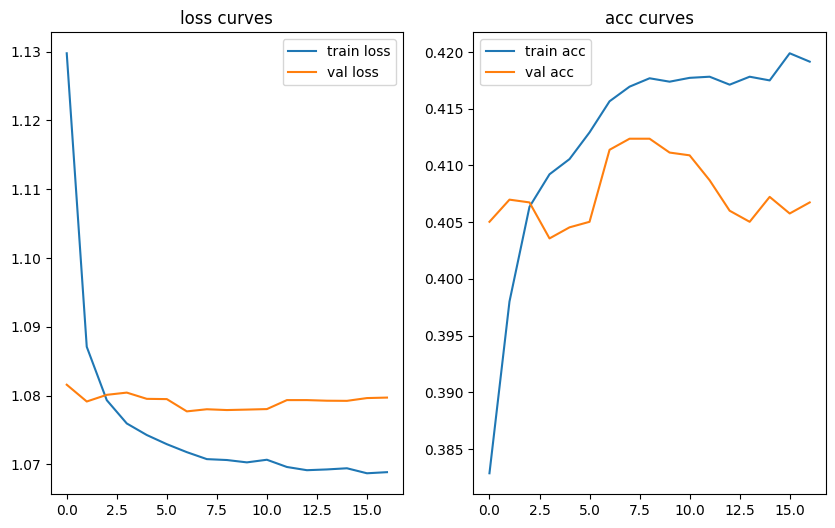

In [21]:
# define model inputs

device = torch.device('cpu')
lr= 1e-3
epochs = 100
scheduler_factor=0.5
scheduler_patience=3
early_stopping_limit = 10
class_weights = [0.889795540181605, 0.6693186731731422, 0.5517017728086973]
criterion = 'cross'

model, train_losses, val_losses, train_accs, val_accs = train(
    device=device,
    lr=lr,
    epochs=epochs,
    scheduler_factor=scheduler_factor,
    scheduler_patience=scheduler_patience,
    early_stopping_limit=early_stopping_limit,
    class_weights=class_weights,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader
)
plot_loss_acc(train_losses, val_losses, train_accs, val_accs)

overall test accuracy: 37.19
acc-sell: 2.106
acc-hold: 48.228
acc-buy: 66.827


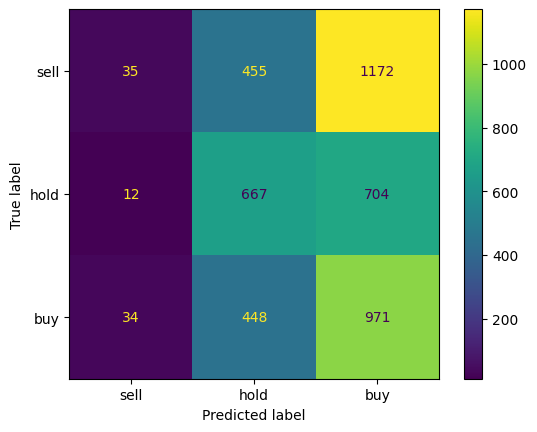

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

best_model_path = 'fcn.pt'
model = FCN()
model.load_state_dict(torch.load(best_model_path,map_location=device))
model.eval()


X_test2 = torch.tensor(X_test, dtype=torch.float32)
y_test2 = torch.tensor(y_test, dtype=torch.float32)

preds = model(X_test2)
softmax_preds = nn.Softmax(dim=1)(preds)
_, class_preds = torch.max(preds, dim=1)

test_acc = accuracy_score(class_preds,y_test2)
print(f"overall test accuracy: {round(test_acc*100,2)}")

labels = ["sell","hold","buy"]
label_mapping = {i:labels[i] for i in range(len(labels))}

cm = confusion_matrix(y_test2, class_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
for i in range(len(cm)):
    print(f"acc-{label_mapping[i]}: {round(cm[i,i]/sum(cm[i])*100,3)}")

disp.plot()
plt.show()

In [23]:
# check softmax values

nn.Softmax(dim=1) (preds)

tensor([[0.1890, 0.5154, 0.2956],
        [0.2011, 0.5159, 0.2830],
        [0.1976, 0.5008, 0.3016],
        ...,
        [0.1707, 0.5360, 0.2933],
        [0.2514, 0.3671, 0.3816],
        [0.2320, 0.4481, 0.3199]], grad_fn=<SoftmaxBackward0>)

In [24]:
## predict on indiv stocks

for stock_name in test_df.stock_name.unique():
    stock_df = test_df[test_df['stock_name']==stock_name]
    stock_X_test = stock_df[features].to_numpy()
    # if use selectKbest
    # stock_X_test = selector.transform(stock_X_test)
    # if use PCA
    stock_X_test = pca.transform(stock_X_test)

    stock_y_test = stock_df[target].to_numpy()
    stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)

    stock_preds = model(stock_X_test)
    softmax_preds = nn.Softmax(dim=1)(stock_preds)
    _, class_preds = torch.max(softmax_preds, dim=1)
    
    acc = accuracy_score(stock_y_test, class_preds.detach().numpy())

    print(f"{stock_name}: {round(acc*100,2)}")

# # choose top 10 from here

RR.L: 24.7
MKS.L: 36.75
III.L: 27.71
MELI: 36.0
INTU: 27.2
SMCI: 34.4
WDAY: 30.4
META: 33.6
BKNG: 28.8
ABNB: 24.8
TSLA: 40.0
ADBE: 29.6
TEAM: 29.6
AMD: 33.6
AMZN: 29.6
DASH: 36.8
DDOG: 36.8
SNPS: 30.4
TTD: 34.4
NVDA: 37.6
AMAT: 35.2
MDB: 29.6
LRCX: 35.2
CRWD: 36.0
AVGO: 37.6
PANW: 30.4
INTC: 29.6
MSFT: 24.0
CDNS: 28.0
MU: 29.6
MRVL: 33.6
MRNA: 34.4
ZS: 32.8
PDD: 34.4
CPRT: 24.8


In [25]:
stock_name = "TTD"

stock_df = test_df[test_df['stock_name']==stock_name]
stock_X_test = stock_df[features].to_numpy()
# if use selectKbest
# stock_X_test = selector.transform(stock_X_test)
# if use PCA
stock_X_test = pca.transform(stock_X_test)

stock_y_test = stock_df[target].to_numpy()
stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)

stock_preds = model(stock_X_test)
softmax_preds = nn.Softmax(dim=1)(stock_preds)
_, class_preds = torch.max(softmax_preds, dim=1)

acc = accuracy_score(stock_y_test, class_preds.detach().numpy())

print(f"{stock_name}: {round(acc*100,2)}")

TTD: 34.4


In [26]:
softmax_preds[:10]

tensor([[0.3746, 0.2437, 0.3817],
        [0.2565, 0.3821, 0.3614],
        [0.3409, 0.2395, 0.4197],
        [0.2981, 0.2868, 0.4151],
        [0.2858, 0.2755, 0.4387],
        [0.3275, 0.3707, 0.3018],
        [0.2775, 0.3792, 0.3433],
        [0.2985, 0.3497, 0.3517],
        [0.2613, 0.3427, 0.3960],
        [0.2952, 0.2797, 0.4251]], grad_fn=<SliceBackward0>)

In [27]:
def threshold_pred(softmax_pred,thre_buy=0.7,thre_sell=0.7):
    if softmax_pred[2] >= thre_buy:
        return 2
    elif softmax_pred[0] >= thre_sell:
        return 0
    else:
        # just hold
        return 1

def get_threshold_preds(softmax_preds,thre_buy=0.7,thre_sell=0.7):
    res = []
    for softmax_pred in softmax_preds:
        pred = threshold_pred(softmax_pred,thre_buy,thre_sell)
        res.append(pred)
    return res

In [28]:
len(stock_y_test)

125

accuracy: 35.2


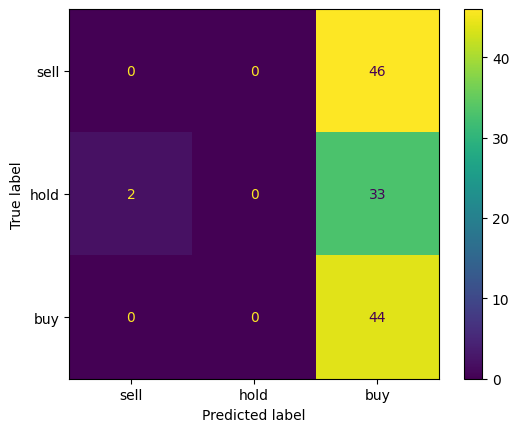

In [29]:
thre_preds = get_threshold_preds(softmax_preds,thre_buy=0.33333,thre_sell=0.303333)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

acc = accuracy_score(thre_preds,stock_y_test)
print(f"accuracy: {round(acc*100,2)}")

cm = confusion_matrix(stock_y_test, thre_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()